In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys,os,time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import rasterio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from sklearn.feature_extraction.image import extract_patches_2d
import cProfile

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
p = pd.read_csv("big_lc_paths.csv", header=None)
paths = p[0].tolist()
palette = np.array([[0,0,0],[0,153,51],[0,102,255],[153,102,51],[255,153,0],[255,255,0],[204,102,153]])
palette_torch = torch.from_numpy(palette[1:,:]).float().to(device)

def cum_sum(arr, s):
    cumsum = torch.cumsum(torch.cumsum(arr,dim=2),dim=3)
    cumsum = F.pad(cumsum,(1,0,1,0),'constant',0)
    tot = cumsum[:,:,:-s,:-s]-cumsum[:,:,s:,:-s]-cumsum[:,:,:-s,s:]+cumsum[:,:,s:,s:]
    return tot

#learns N x N epitome from T, K x K random patches drawn from input image x.
#Applies NIT iterations of the E-M algorithm at scales sc; T*sc^2 patches are sampled.
#no longer accepts initializations of e or ev
#e,ev = initial epitome mean and variance. The mean is initialized
#to the uniform image with some small noise, and the variance is initialized to 1
#p holds an array of probabilities of using each part of the epitome

def epitome(x,K,N,T,NIT,sc):
    xFIN = x
    x = F.interpolate(x,scale_factor=sc[0])#x = torch.clamp(F.interpolate(x,scale_factor=sc[0]),min=0,max=1)
    _, numDim, SY, SX = x.shape
    TFIN = T
    T = int(np.ceil(T*sc[0]**2))
    NFIN = N
    N = int(np.ceil(sc[0]*N))
    e = torch.zeros((1,numDim,N,N)).to(device)#mean of image plus noise
    ev = torch.ones((1,numDim,N,N)).to(device)/50
    for i in range(numDim):
        e[:,i,:,:] = x[0,i,:,:].std()*torch.randn(N,N).to(device)/100+x[0,i,:,:].mean()
    p = torch.ones((N,N)).to(device)/N**2
    MINP = 1e-8#1e-8 is acceptable
    MINV = 1e-2#1e-6
    #etr = torch.zeros((NIT+1,1,numDim,NFIN,NFIN))
    #etr[0,:,:,:,:] = F.interpolate(e,[NFIN,NFIN])
    #perform NIT iterations of EM algorithm
    for sci in range(len(sc)):
        if sci != 0:
            N = int(np.ceil(sc[sci]*NFIN))
            e = F.interpolate(e,[N,N]).to(device)#e = torch.clamp(F.interpolate(e,[N,N]),min=0,max=1).to(device)
            ev = F.interpolate(ev,[N,N]).to(device)#ev = torch.clamp(F.interpolate(ev,[N,N]),min=MINV).to(device)
            p = torch.ones((N,N)).to(device)/N**2
            #x = torch.clamp(F.interpolate(xFIN,scale_factor=sc[sci]),min=0,max=1).to(device)
            x = F.interpolate(xFIN,scale_factor=sc[sci]).to(device)
            T = int(np.ceil(sc[sci]**2*TFIN))
        sumP = torch.zeros((N,N),dtype=torch.float).to(device)
        sumPy = torch.zeros((numDim,N,N),dtype=torch.float).to(device)
        sumPy2 = torch.zeros((numDim,N,N),dtype=torch.float).to(device)
        ewrap = torch.zeros((numDim,N+K-1,N+K-1),dtype=torch.float).to(device)
        evwrap = torch.zeros((numDim,N+K-1,N+K-1),dtype=torch.float).to(device)
        SY = x.shape[2]
        SX = x.shape[3]
        patchnum = min(T,(SY-K)**2)
        ytemp = np.rollaxis(extract_patches_2d(torch.squeeze(x).permute(1,2,0),(K,K),max_patches=patchnum),3,1)
        y = torch.from_numpy(ytemp).float().to(device)
        for nit in range(NIT):
            #glues together borders of e
            ewrap[:,:N,:N] = e;
            ewrap[:,N:,:] = ewrap[:,:K-1,:]
            ewrap[:,:,N:] = ewrap[:,:,:K-1]
            evwrap[:,:N,:N] = ev
            evwrap[:,N:,:] = evwrap[:,:K-1,:]
            evwrap[:,:,N:] = evwrap[:,:,:K-1]
            evwrapi = 1./evwrap
            # E STEP
            sumP[:,:] = 0
            sumPy[:,:,:] = 0
            sumPy2[:,:,:] = 0
            yt = torch.flip(y,[2,3])
            tmp3 = torch.sum(torch.squeeze(cum_sum(torch.unsqueeze(ewrap**2*evwrapi,0),K)),dim=0)
            tmp4 = torch.sum(torch.squeeze(cum_sum(torch.unsqueeze(torch.log(evwrap),0),K)),dim=0)
            idxp = 0
            batch_size = 9001
            while idxp*batch_size<patchnum:
                ytc = yt[idxp*batch_size:idxp*batch_size+batch_size,:,:,:]
                tmp1full = torch.squeeze(F.conv2d(torch.unsqueeze(evwrapi,0),ytc**2))
                tmp2full = torch.squeeze(F.conv2d(torch.unsqueeze(ewrap*evwrapi,0),ytc))
                for tx in range(tmp1full.shape[0]):
                    t = batch_size*idxp+tx
                    lP = torch.log(p)-.5*(tmp4+tmp1full[tx,:,:]-2*tmp2full[tx,:,:]+tmp3)
                    P = torch.exp(lP-torch.max(lP))+MINP
                    P /= torch.sum(P)
                    tmp = F.pad(P.view(1,1,N,N),(K-1,K-1,K-1,K-1),'constant',0).to(device)
                    tmp_sumP = torch.squeeze(cum_sum(tmp,K))
                    tmp_sumP[:,:K-1] += tmp_sumP[:,N:]
                    tmp_sumP[:K-1,:] += tmp_sumP[N:,:]
                    sumP += tmp_sumP[:N,:N]
                    yctmp = torch.unsqueeze(y[t,:,:,:],1)
                    tmp_sumPy = torch.squeeze(F.conv2d(tmp,yctmp))
                    tmp_sumPy[:,:,:K-1] += tmp_sumPy[:,:,N:]
                    tmp_sumPy[:,:K-1,:] += tmp_sumPy[:,N:,:]
                    sumPy += tmp_sumPy[:,:N,:N]
                    tmp_sumPy2 = torch.squeeze(F.conv2d(tmp,yctmp**2))
                    tmp_sumPy2[:,:,:K-1] += tmp_sumPy2[:,:,N:]
                    tmp_sumPy2[:,:K-1,:] += tmp_sumPy2[:,N:,:]
                    sumPy2 += tmp_sumPy2[:,:N,:N]
                torch.cuda.empty_cache()
                idxp += 1
            #del tmp1full, tmp2full,tmp,tmp_sumPy,tmp_sumPy2
            #torch.cuda.empty_cache()
            #M STEP
            #p = sumP/torch.sum(sumP)#commented out
            e[0,:,:,:] = sumPy/sumP
            if nit>10 or sci>0:
                ev[0,:,:,:] = sumPy2/sumP - 2*e[0,:,:,:]*sumPy/sumP+e[0,:,:,:]**2
            ev = torch.clamp(ev,min=MINV)
            etemp = F.interpolate(e,[NFIN,NFIN])
            #etr[nit+1,:,:,:] = etemp
            fig=plt.figure(figsize=(14,5))
            fig.add_subplot(131)
            plt.axis('off')
            plt.imshow(etemp[0,:3,:,:].permute(1,2,0))
            plt.title(str(N)+'^2 epitome')
            e_colors = e[0,4:,:,:].permute(1,2,0).view(-1,6)
            fig.add_subplot(132)
            plt.axis('off')
            plt.imshow(torch.matmul(e_colors,palette_torch).view(N,N,3)/256)
            plt.title('labeled epitome')
            fig.add_subplot(133)
            plt.axis('off')
            plt.imshow(torch.sum(torch.squeeze(ev),dim=0),cmap='hot',interpolation='nearest')
            plt.title('variances')
            plt.show()
            plt.close()   
        torch.cuda.empty_cache()
    return e,ev,p#,etr

#Replaces the epitome (e,ev) of an image by another epitome image emod
#keeping the mapping intact. The routine can be used to edit images or to
#preprocess by coloring the image accoring to the image.
#K is the patch size in mapping inference and SPC is the patch spacing.

def reconstruct(x,K,e,ev,emod,SPC):
    _,NoCh1,SY,SX = x.shape
    NoCh2 = emod.shape[0]
    if NoCh1 == 1:
        x = torch.stack((x,x,x),dim=0)
    N = e.shape[2]
    ewrap = torch.zeros((1,NoCh1,N+K-1,N+K-1)).to(device)
    evwrap = torch.zeros((1,NoCh1,N+K-1,N+K-1)).to(device)
    ewrap[0,:,:N,:N] = e
    ewrap[:,:,N:,:] = ewrap[:,:,:K-1,:]
    ewrap[:,:,:,N:] = ewrap[:,:,:,:K-1]
    evwrap[0,:,:N,:N] = ev
    evwrap[:,:,N:,:] = evwrap[:,:,:K-1,:]
    evwrap[:,:,:,N:] = evwrap[:,:,:,:K-1]
    evwrapi = 1./evwrap
    tmp3 = torch.sum(torch.squeeze(cum_sum(ewrap**2*evwrapi,K)),dim=0)
    tmp4 = torch.sum(torch.squeeze(cum_sum(torch.log(evwrap),K)),dim=0)
    emodwrap = torch.zeros((NoCh2,N+K-1,N+K-1)).to(device)
    emodwrap[:,:N,:N] = emod
    emodwrap[:,N:,:] = emodwrap[:,:K-1,:]
    emodwrap[:,:,N:] = emodwrap[:,:,:K-1]
    z = torch.zeros((NoCh2,SY,SX)).to(device)
    cnt = torch.zeros((SY,SX)).to(device)
    ixt = 0
    iyt = 0
    #MINP = 1e-8
    #for each patch of the input, find the distribution over the epitome positions,
    #and reconstruct the patch in the input image, using the modified epitome.
    for iy in range(0,SY-K+1,SPC):
        print('iy='+str(iy))
        for ix in range(0,SX-K+1,SPC):
            #watch for indexing errors
            yct = torch.flip(x[:,:,iy:iy+K,ix:ix+K],[2,3])#1 x channels x K x K
            tmp1 = torch.squeeze(F.conv2d(evwrapi,yct**2))
            tmp2 = torch.squeeze(F.conv2d(ewrap*evwrapi,yct))
            lP = -.5*(tmp4+tmp1-2*tmp2+tmp3)#N x N (256^2)
            #P = torch.exp(lP-torch.max(lP))#+MINP
            #P /= torch.sum(P)
            #argmax = torch.argmax(P)
            argmax = torch.argmax(lP)
            mxpi = argmax//lP.shape[0]
            mxpj = argmax - mxpi*lP.shape[0]
            #watch for indexing errors
            z[:,iy:iy+K,ix:ix+K] += emodwrap[:,mxpi:mxpi+K,mxpj:mxpj+K]
            cnt[iy:iy+K,ix:ix+K] += 1
            ixt = ix
        iyt = iy
    #print(ixt,iyt,z.shape)
    z = z[:,:iyt+K,:ixt+K]
    cnt = cnt[:iyt+K,:ixt+K]
    z /= cnt
    return z

In [104]:
#create a 10 channel structure from tile t at (x,y) of size... size
def t_load(t,x,y,size):
    naip_tile = rasterio.open('/mnt/blobfuse/esri-naip/'+paths[t][:-7]+'.mrf','r')
    naip = naip_tile.read().astype(float)/255.
    naip_tile.close()
    lc_tile = rasterio.open('/mnt/blobfuse/resampled-lc/'+paths[t],'r')
    lc = np.squeeze(lc_tile.read())
    lc_tile.close()
    lc[lc==1]=10
    lc[lc==2]=1
    lc[lc==10]=2
    lc[lc==4]=0
    lc[lc==15]=4
    t = np.zeros((10,size,size),dtype=float)
    t[:4,:,:] = naip[:,x:x+size,y:y+size]
    query_lc = lc[x:x+size,y:y+size]
    for i in range(6):
        t[4+i,:,:] = (query_lc==(i+1))
    t = np.expand_dims(t,axis=0)
    return torch.from_numpy(t).float().to(device)

#display 10 channel structure
def disp_10(t):
    fig=plt.figure(figsize=(14,10))
    fig.add_subplot(121)
    plt.axis('off')
    plt.imshow(t[0,:3,:,:].permute(1,2,0))
    fig.add_subplot(122)
    plt.axis('off')
    plt.imshow(palette[get_labels(t)])
    plt.show()
    plt.close()
    
def get_labels(t):
    return torch.argmax(t[0,4:,:,:],dim=0)+1    

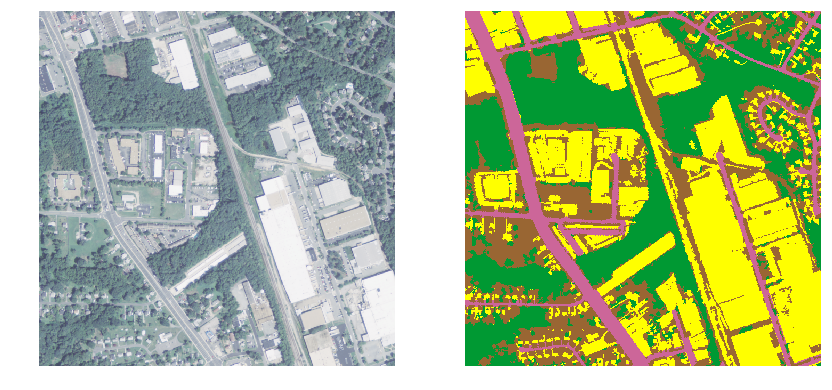

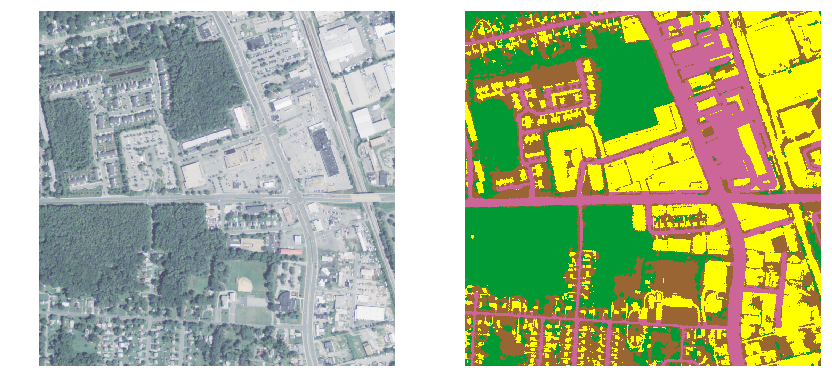

In [117]:
tr = t_load(5,0,0,1024)
disp_10(tr)
ts = t_load(5,1024,0,1024)
disp_10(ts)

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/feature_extraction/image.py:287: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides


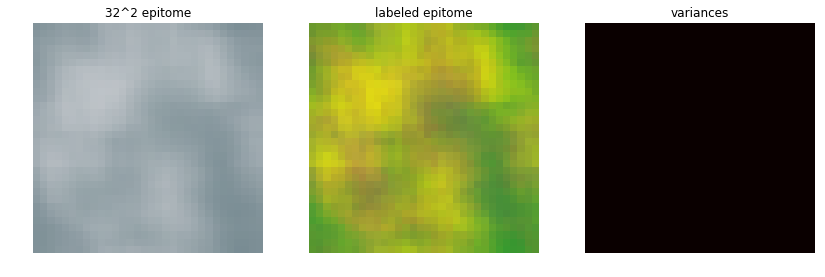

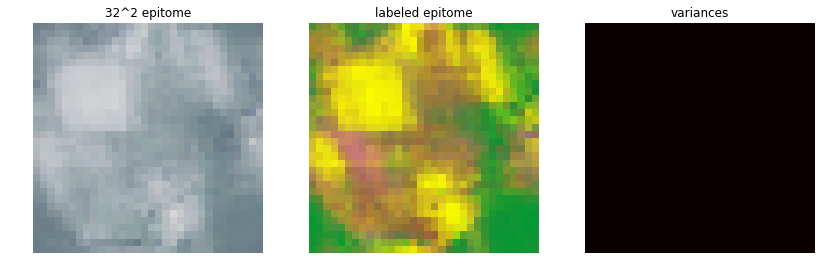

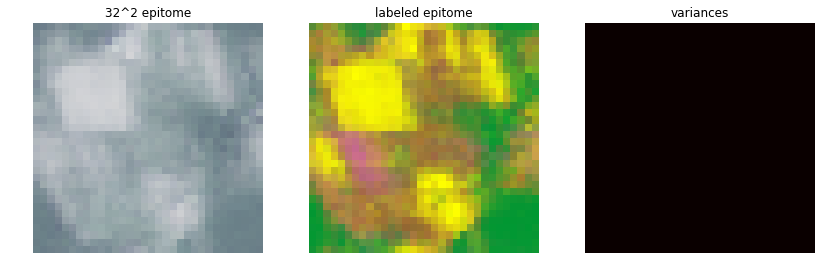

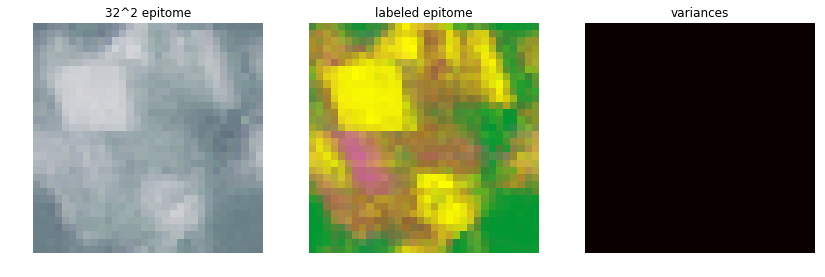

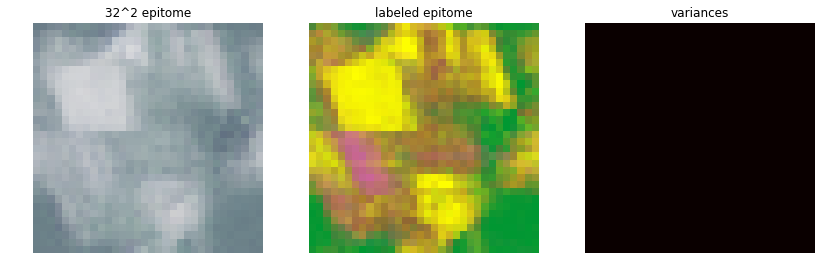

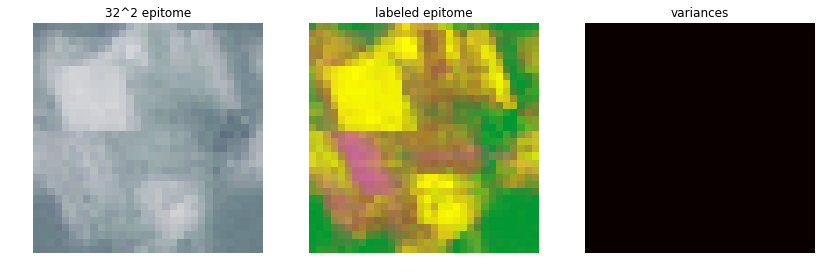

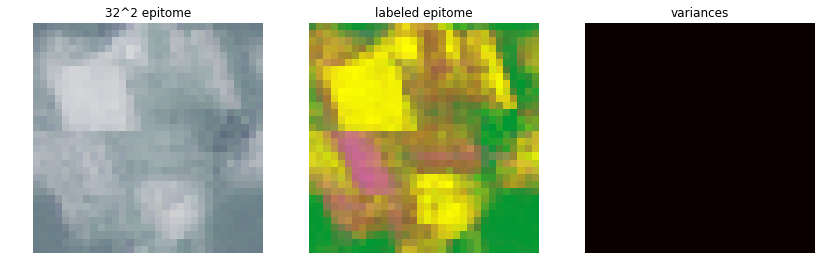

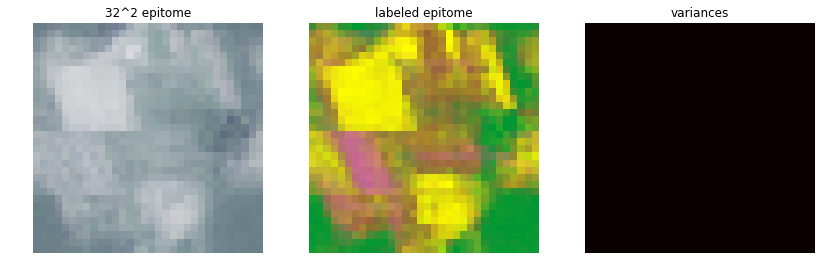

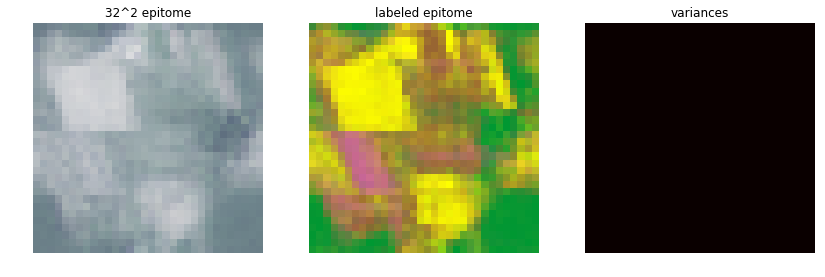

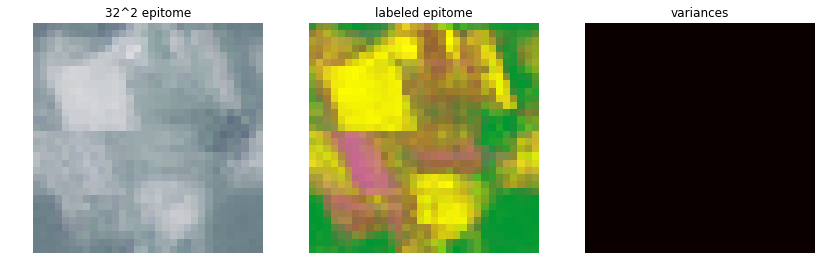

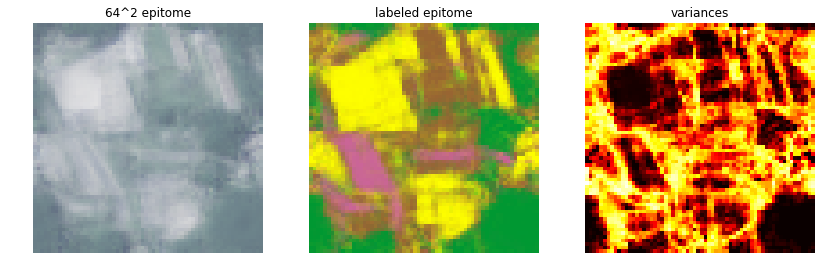

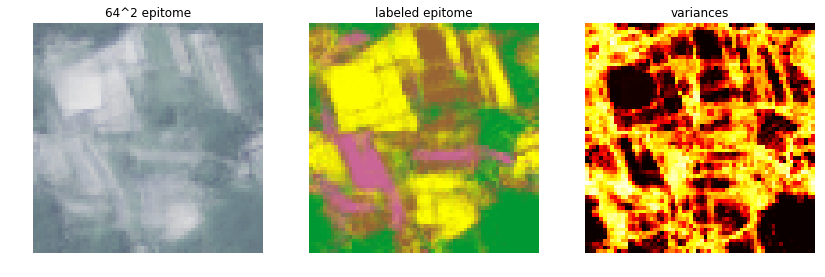

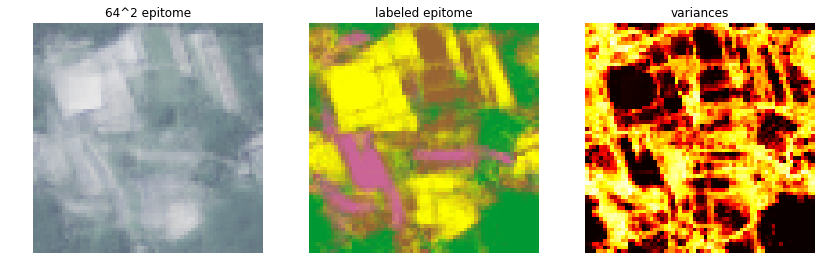

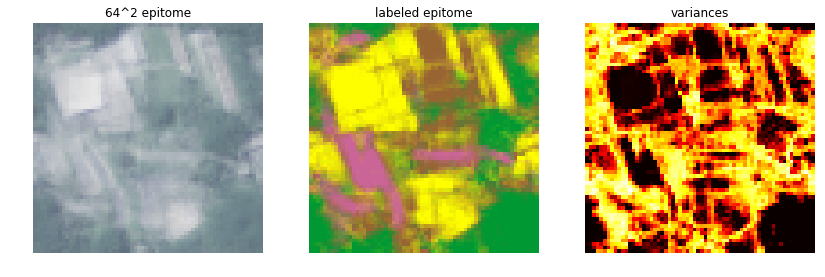

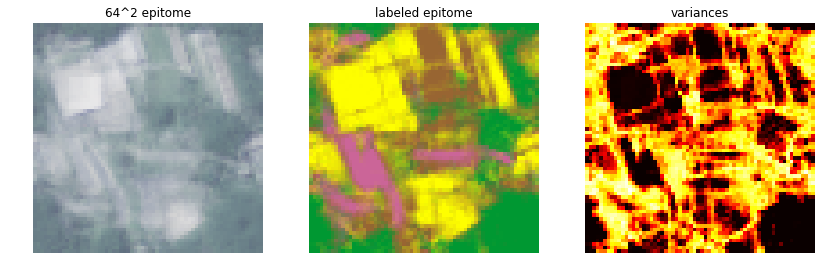

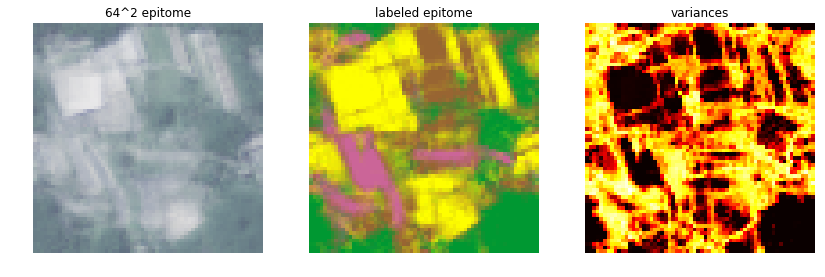

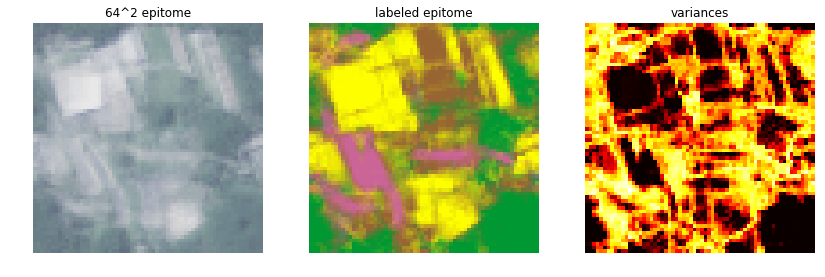

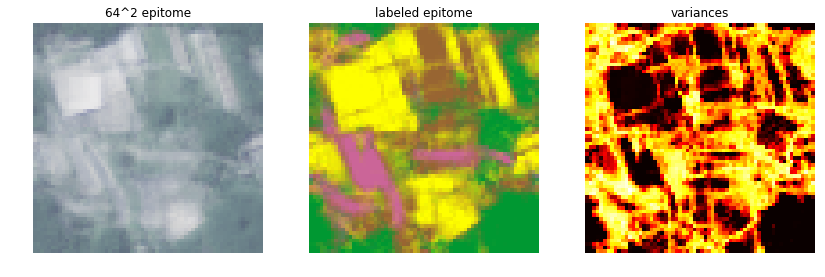

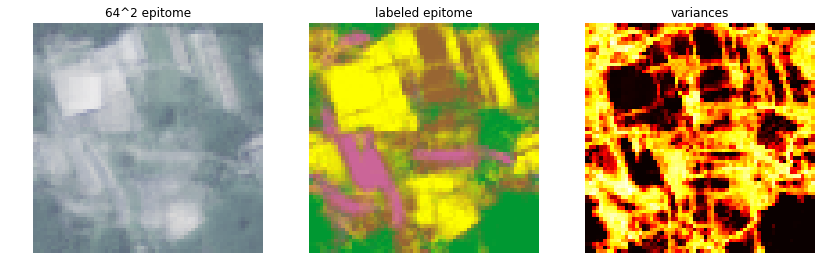

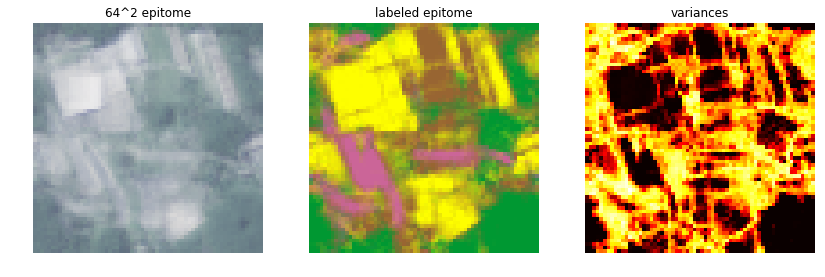

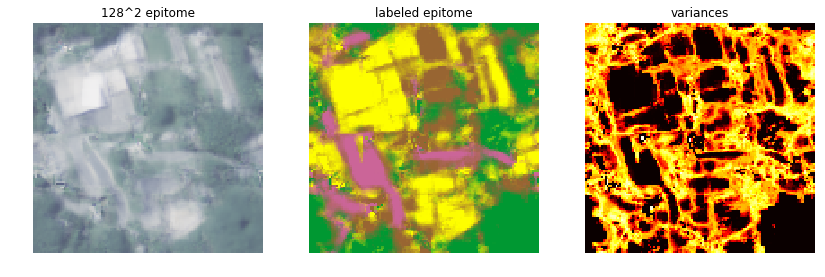

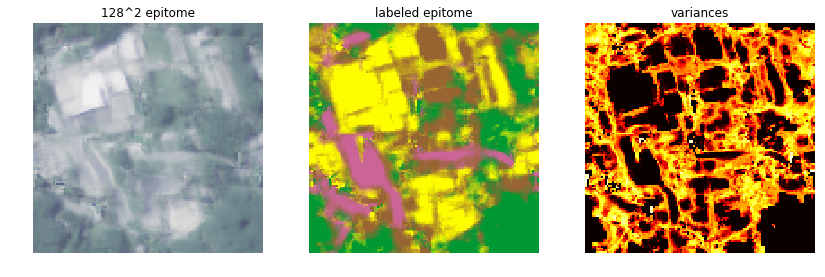

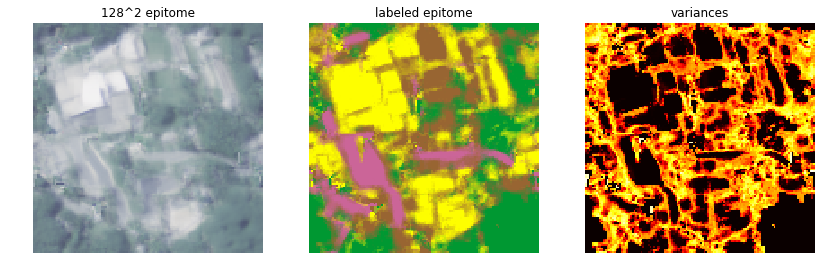

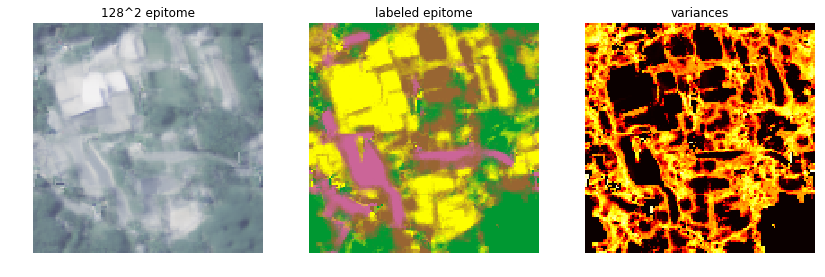

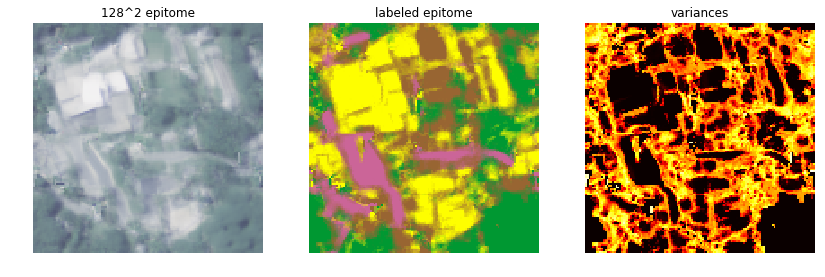

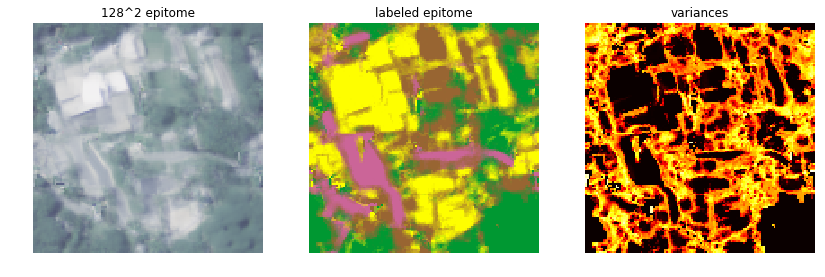

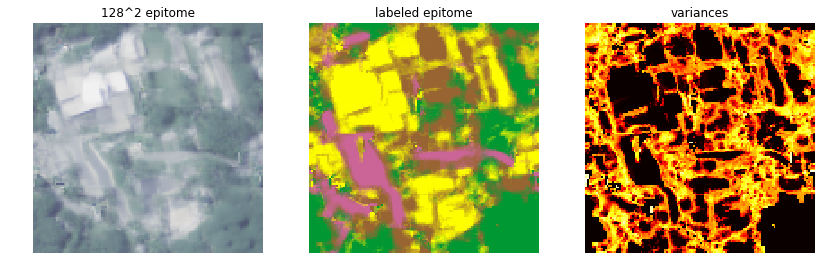

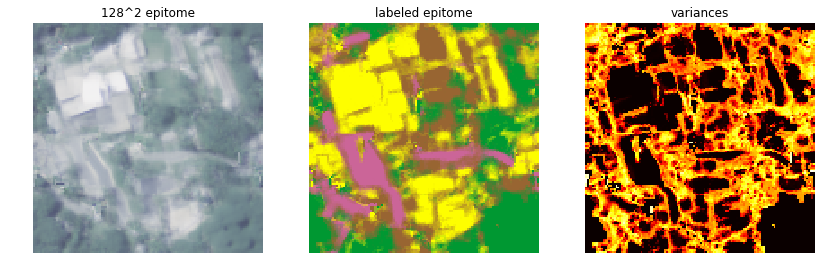

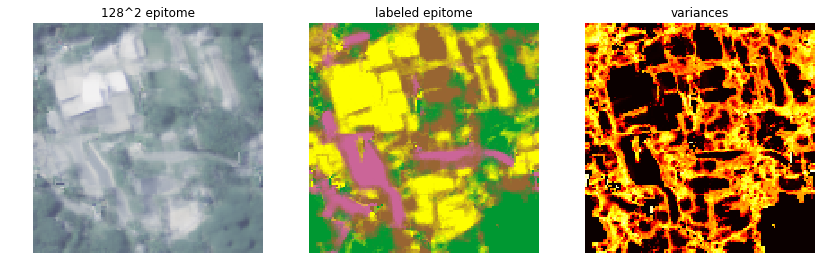

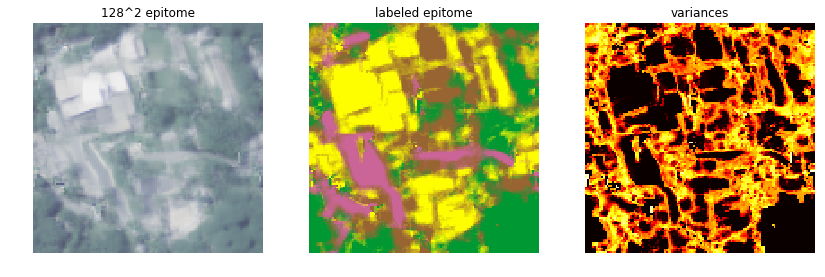

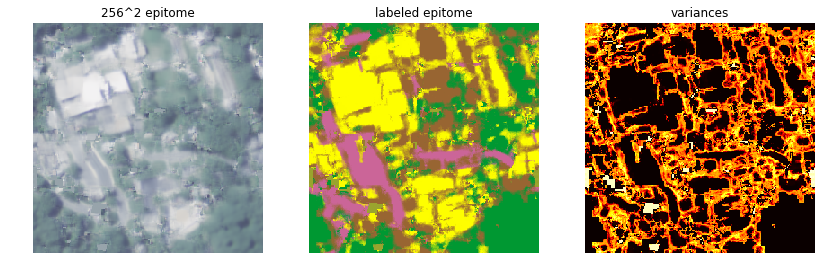

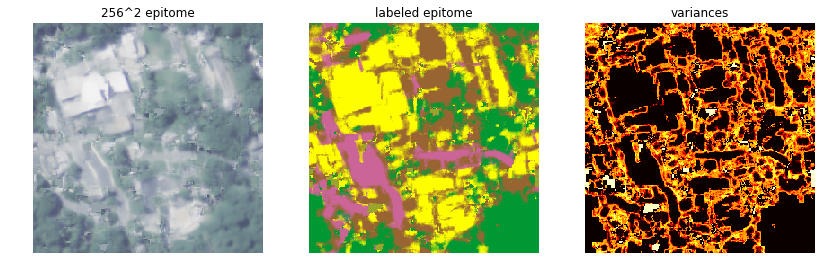

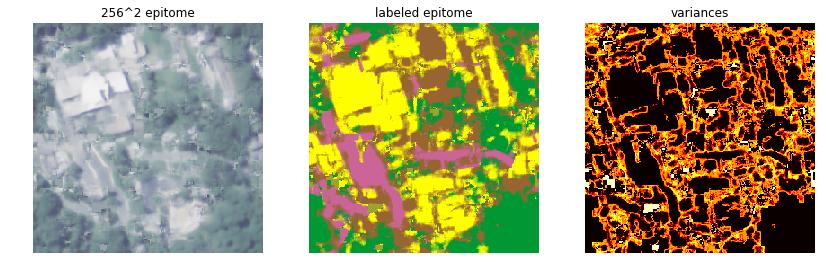

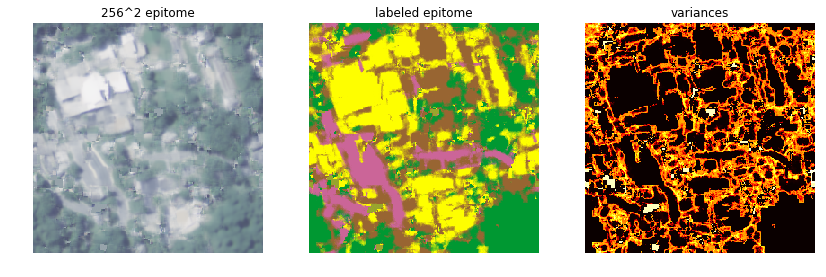

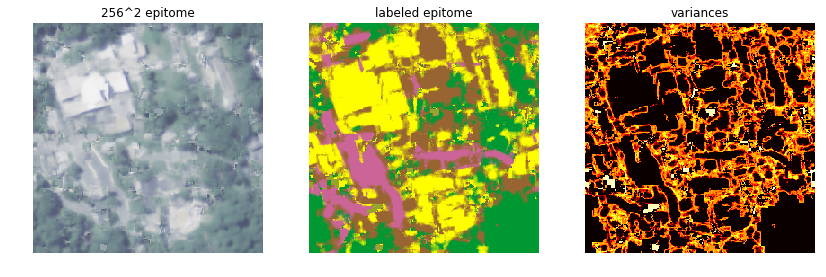

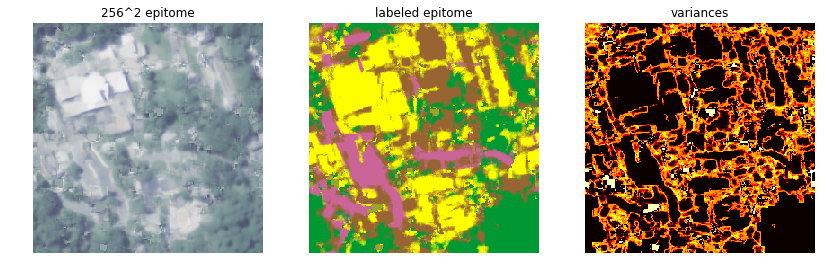

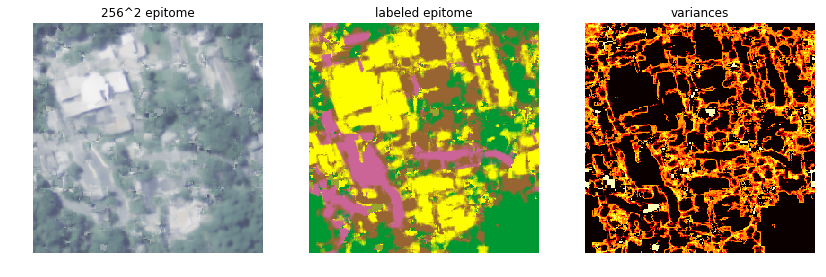

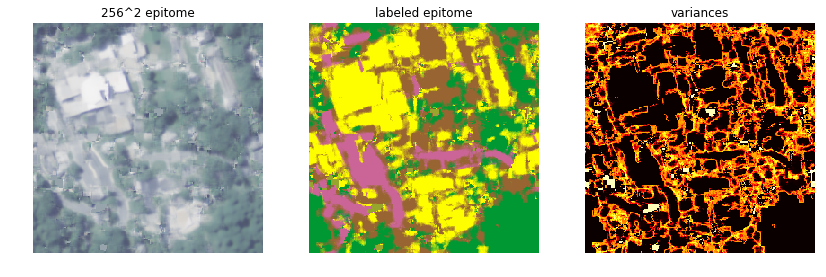

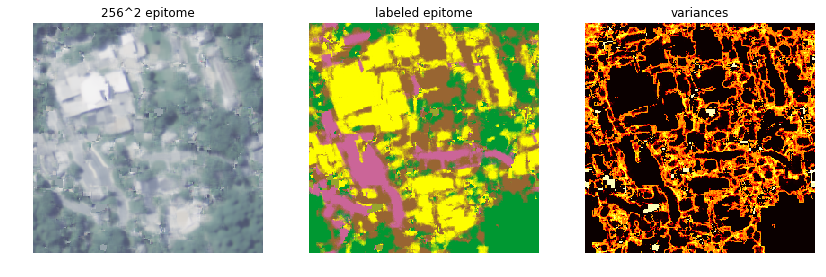

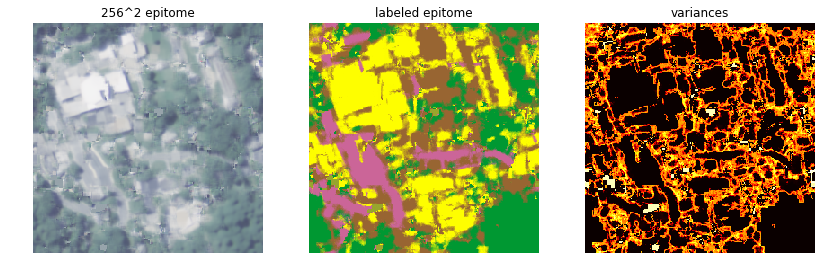

         41974238 function calls (41840398 primitive calls) in 957.292 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000  957.292  957.292 {built-in method builtins.exec}
        1    0.001    0.001  957.292  957.292 <string>:1(<module>)
        1  322.080  322.080  957.291  957.291 <ipython-input-98-64a9abee3169>:20(epitome)
   531250  276.965    0.001  276.965    0.001 {built-in method max}
   531330   55.590    0.000  123.383    0.000 <ipython-input-98-64a9abee3169>:7(cum_sum)
  1062580    3.661    0.000  111.043    0.000 functional.py:2112(pad)
  1062580   10.080    0.000  106.719    0.000 {built-in method apply}
  1062580   24.750    0.000   96.639    0.000 padding.py:12(forward)
  1062680   76.534    0.000   76.534    0.000 {built-in method conv2d}
   531370   36.261    0.000   36.261    0.000 {built-in method sum}
  3187660   18.580    0.000   18.580    0.000 {method 'narrow' of 'torch._C.

      360    0.001    0.000    0.004    0.000 _base.py:1290(set_aspect)
      960    0.002    0.000    0.004    0.000 axis.py:2440(get_view_interval)
       40    0.000    0.000    0.004    0.000 pretty.py:502(_default_pprint)
      640    0.001    0.000    0.004    0.000 core.py:214(_recursive_fill_value)
      160    0.000    0.000    0.004    0.000 backend_bases.py:2337(mpl_connect)
     8280    0.004    0.000    0.004    0.000 lines.py:537(set_markevery)
     3720    0.003    0.000    0.003    0.000 axis.py:215(get_tick_padding)
       80    0.003    0.000    0.003    0.000 {method 'draw_path' of 'matplotlib.backends._backend_agg.RendererAgg' objects}
      200    0.000    0.000    0.003    0.000 {method 'any' of 'numpy.ndarray' objects}
      720    0.002    0.000    0.003    0.000 spines.py:148(get_patch_transform)
       40    0.000    0.000    0.003    0.000 pretty.py:698(_repr_pprint)
     8280    0.003    0.000    0.003    0.000 stride_tricks.py:254(<genexpr>)
     1560    0.

       80    0.000    0.000    0.000    0.000 {method 'pop' of 'list' objects}
       80    0.000    0.000    0.000    0.000 backend_bases.py:2046(draw)
       50    0.000    0.000    0.000    0.000 functional.py:1934(_check_size_scale_factor)
      120    0.000    0.000    0.000    0.000 gridspec.py:428(get_gridspec)
      120    0.000    0.000    0.000    0.000 _subplots.py:123(get_subplotspec)
       80    0.000    0.000    0.000    0.000 patches.py:233(get_facecolor)
      120    0.000    0.000    0.000    0.000 {method 'remove' of 'set' objects}
       40    0.000    0.000    0.000    0.000 {method 'copy' of 'dict' objects}
      120    0.000    0.000    0.000    0.000 tight_bbox.py:35(_l)
       80    0.000    0.000    0.000    0.000 patches.py:226(get_edgecolor)
       80    0.000    0.000    0.000    0.000 backend_bases.py:1019(set_antialiased)
       40    0.000    0.000    0.000    0.000 {method 'clear' of 'dict' objects}
        4    0.000    0.000    0.000    0.000 validati

In [99]:
#cProfile.run('e,ev,p,etr=epitome(trIMtorch,9,256,40000,10,[.125,.25,.5,1])',sort='cumtime')
cProfile.run('e,ev,p=epitome(tr,9,256,40000,10,[.125,.25,.5,1])',sort='cumtime')
torch.cuda.empty_cache()

In [ ]:
cProfile.run('z=reconstruct(ts[:,:4,:,:],9,e[0,:4,:,:],ev[0,:4,:,:],e[0,4:,:,:],4)',sort='cumtime')
torch.cuda.empty_cache()

iy=0
iy=4
iy=8
iy=12
iy=16
iy=20
iy=24
iy=28
iy=32
iy=36
iy=40
iy=44
iy=48
iy=52
iy=56
iy=60
iy=64
iy=68
iy=72
iy=76
iy=80
iy=84
iy=88
iy=92
iy=96
iy=100
iy=104
iy=108
iy=112
iy=116
iy=120
iy=124
iy=128
iy=132
iy=136
iy=140
iy=144
iy=148
iy=152
iy=156
iy=160
iy=164
iy=168
iy=172
iy=176
iy=180
iy=184
iy=188
iy=192
iy=196
iy=200
iy=204
iy=208
iy=212
iy=216
iy=220
iy=224
iy=228
iy=232
iy=236
iy=240
iy=244
iy=248
iy=252
iy=256
iy=260
iy=264
iy=268
iy=272
iy=276
iy=280
iy=284
iy=288
iy=292
iy=296
iy=300
iy=304
iy=308
iy=312
iy=316
iy=320
iy=324
iy=328


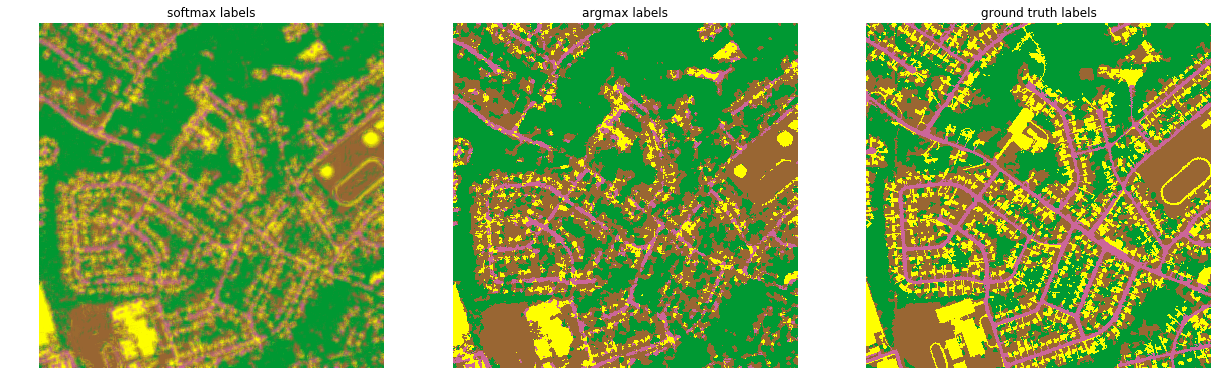

In [112]:
#np.savez_compressed('reconstruction',a=z)
#z2 = F.softmax(z.permute(1,2,0)*10,dim=2)
zmax = torch.argmax(z,dim=0).int()+1
z2 = z.permute(1,2,0)
labels = torch.matmul(z2,palette_torch)/256
#labels = labels.view(z2.shape[0],z2.shape[1],3)/256
fig=plt.figure(figsize=(21,14))
fig.add_subplot(131)
plt.axis('off')
plt.title('softmax labels')
plt.imshow(labels)
fig.add_subplot(132)
plt.axis('off')
plt.title('argmax labels')
plt.imshow(palette[zmax])
fig.add_subplot(133)
plt.axis('off')
plt.title('ground truth labels')
plt.imshow(palette[get_labels(ts)])
plt.show()
plt.close()

In [116]:
error=zmax.cpu().numpy()-get_labels(ts)[:-1,:-1]
print(torch.sum(error==0).float()/1023**2)

tensor(0.6551)
